In [81]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import test_result
from utils.mean_variance import *
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A test for the risk-budgeting model

## Data/Stock choosing:
1. 2010-2022年中一直在上证300中的股票-52只
2. Monthly period from 2010 - 2022. 


In [82]:
crt_dir = os.path.abspath("")
data_dir = os.path.abspath("data")


Read in monthly return rates the 52 stocks and risk free rates from 2009-12 to 2022-12.

In [83]:
R_df = pd.read_csv(os.path.join(
    data_dir, "Monthly_Return_Rates.csv"), index_col=0, parse_dates=True)
R_df = R_df.fillna(0)
rf_df = pd.read_csv(os.path.join(
    data_dir, "Monthly_rf_Rates.csv"), index_col=0, parse_dates=True)
rf_df = rf_df.fillna(0)
rf_df = rf_df


Compute monthly **excess** return rates:

In [84]:
from utils import data_prep
R_excess_df = data_prep.get_excess_return_rates(R_df, rf_df)


CSI300 monthly return:

In [85]:
CSI300_df = pd.read_csv(os.path.join(
    data_dir, "000300.csv"), index_col=1, parse_dates=True)['Idxrtn']


# Construct Portfolio

* Consider the optimization problem: 

\begin{aligned}
\min_{w} & \quad \sum_{i=1}^N RC_i(w)\\
\textrm{s.t.} & \quad  \boldsymbol{1}^Tw \leq 1.5\\
                   & \quad w  \geq \boldsymbol{0}\\
\end{aligned}


* Following the logic from sta4020 asg7. Starting from the end of 2015, at the end of every month, use the historical asset returns (from 2011/1 to the end of that month).

**Estimated Excess Return after 2017; And corresponding portfolio.**

**Please note that there are clear descriptions for the functions and constraint, please remember to check before implementing the models**

To add other constraints, please refer to `cons_*()` in `mean_variance.py`. For example, we implemented the box constraints for $RC_i(w)$: $$\boldsymbol{L} \leq RC(w) \leq \boldsymbol{U}.$$

You can add the box constraints by adding `cons_sum_weight_lower_bound(L)` and `cons_sum_weight_upper_bound(U)` to the `constraint_list`. Note that L and U are N-dimension vector, given N assets.

In [93]:
R_excess_df_i = R_excess_df.iloc[-24:,:]
numOfDays = R_excess_df_i.index.unique().size
R_excess_df_i
numOfDays

24

In [213]:
sum_weight = 1.5
constraint_list = [
    cons_non_negative_weight(), cons_sum_weight_upper_bound(sum_weight)]
# mp = 30, rank = 30,month = 12
R_excess_hat, w_hat = portfolio_construction(
    momentum_period=3, rank=30, R_excess_df=R_excess_df,rf_df=rf_df, momentum_atLeast=0.05, num_atLeast=1,month = 12, objective=obj_Exp_minus_RC, constraints=constraint_list)


**Compute net excess return; and recover net return by adding risk-free return.**

In [214]:
R_net_hat = np.sum(R_excess_hat, axis=1) + \
    rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
R_net_hat=R_net_hat-(sum_weight-1)*rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1)
R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                            'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)
test_result.calculate_result(
    R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])


,accu_return,annual_return,annual_vol,sharpe_ratio,max_dd,winning_rate,karmar
0,2.05618,0.20782,6.943407,0.02849,-0.683575,0.492958,3.007979


#### Todo: 调参

In [ ]:

accumalte_list = []
def rank_function(momentum,month):
    for i in range(10,90,10):#i is the 52-i stock we decide to keep according to momentum
        R_excess_hat, w_hat = portfolio_construction(momentum_period=momentum, rank=i, R_excess_df=R_excess_df, rf_df=rf_df,momentum_atLeast=0.05, num_atLeast=1,month = month, objective=obj_Exp_minus_RC, constraints=constraint_list)
        R_net_hat = np.sum(R_excess_hat, axis=1) + \
    rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
        R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                            'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)

        result_df = test_result.calculate_result(R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])
        accumalte_list.append(result_df['accu_return'].values[0])
        p_cum = (R_net_hat_df['return'] + 1).cumprod()
        plt.plot(p_cum,label = 'rank '+str(i))
    plt.legend()
    plt.title('rank comparision with momentum_period '+str(momentum )+' and month '+str(month))
    plt.show()


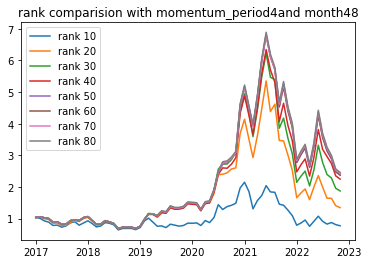

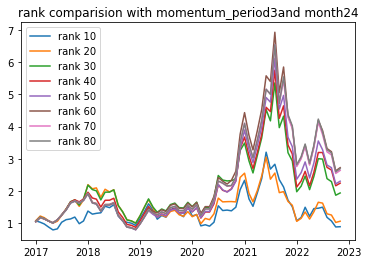

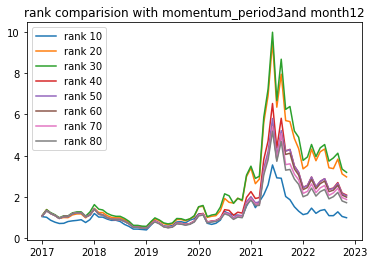

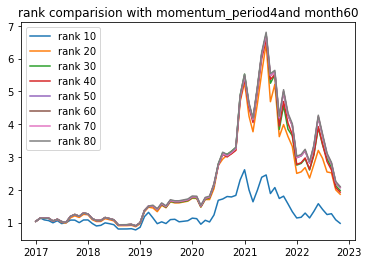

In [208]:
rank_function(4,48)
rank_function(3,24)
rank_function(3,12)
rank_function(4,60)


In [217]:
accumalte_list = []
def momentum_function(rank,month):
    for j in range(1,6):#i is the 52-i stock we decide to keep according to momentum
            R_excess_hat, w_hat = portfolio_construction(momentum_period=j, rank=rank, R_excess_df=R_excess_df, rf_df=rf_df,momentum_atLeast=0.05, num_atLeast=1, month=month, objective=obj_Exp_minus_RC, constraints=constraint_list)
            R_net_hat = np.sum(R_excess_hat, axis=1) + \
        rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
            R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                                'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)

            result_df = test_result.calculate_result(R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])
            accumalte_list.append(result_df['accu_return'].values[0])
            p_cum = (R_net_hat_df['return'] + 1).cumprod()
            plt.plot(p_cum,label = 'momentum_period '+str(j)+'months')
    plt.legend()
    plt.title('momentum_period comparision')
    plt.show()

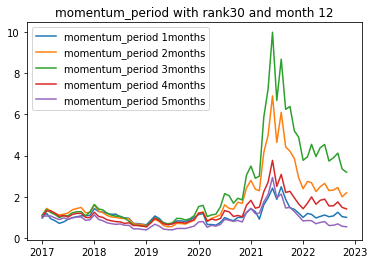

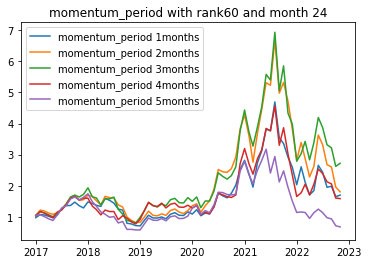

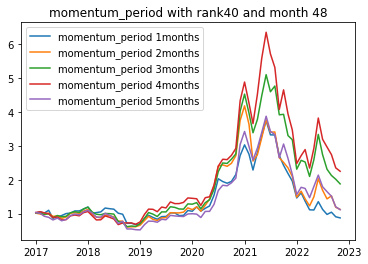

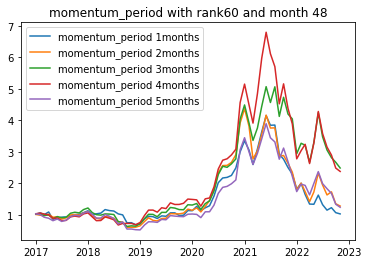

In [218]:
momentum_function(30,12)
momentum_function(60,24)
momentum_function(40,48)
momentum_function(60,48)

**Construct equal weighted portfolio**

In [ ]:
ew_rets = pd.DataFrame(np.sum(
    1.0*R_df[R_df.index >= pd.Timestamp("2017")]/R_df.shape[1], axis=1), columns=['return'])
rf_rets = pd.DataFrame(
    rf_df[rf_df.index.year>=2017].values, columns=['return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index
)

**Plot the portfolio cumulative returns**

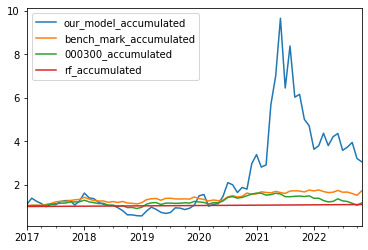

In [198]:
p_cum = (R_net_hat_df['return'] + 1).cumprod()
ew_cum = (ew_rets['return'] + 1).cumprod()
CSI300_cumrets = (CSI300_df[CSI300_df.index.year >= 2017] + 1).cumprod()
rf_cumrets = (rf_rets+1).cumprod()
pd.concat([p_cum, ew_cum, CSI300_cumrets, rf_cumrets], axis=1).plot()
plt.legend(['our_model_accumulated',
           'bench_mark_accumulated', '000300_accumulated', 'rf_accumulated'])
plt.show()


* maximize the sharp ratio and the formula derivation: this repository may helps

https://github.com/PaiViji/PythonFinance--RiskBudgeted-Portfolio-Construction.git

* we can also use this repository to check the quality of our work:

https://github.com/jcrichard/pyrb.git

In [ ]:
tmp_df = pd.read_csv('./data/Monthly_Excess_Return_Rates.csv',index_col=0,parse_dates=True)
df_2021 = tmp_df[tmp_df.index.year == 2020]
df_2022 = tmp_df[tmp_df.index.year == 2022]

In [ ]:
f = df_2021.describe()
f.loc['mean'].mean()

0.007446748397435898

In [ ]:
e = df_2022.describe()
e.loc['mean'].mean()

-0.0017987534965034939